<a href="https://colab.research.google.com/github/SibiSenthur/Python-Projects-/blob/master/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Importing the necessary libraries










In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from fbprophet import Prophet
!pip install pmdarima
from numpy import log
import pmdarima
from pmdarima import auto_arima

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Importing the datafile and preparing the data; 
# I have imported the dataset into Colab Notebooks residing within my google drive.
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv', sep = ',')
df.shape
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)
df.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2/5/2010,24924.50,False
1,1,1,2/12/2010,46039.49,True
2,1,1,2/19/2010,41595.55,False
3,1,1,2/26/2010,19403.54,False
4,1,1,3/5/2010,21827.90,False
5,1,1,3/12/2010,21043.39,False
6,1,1,3/19/2010,22136.64,False
7,1,1,3/26/2010,26229.21,False
8,1,1,4/2/2010,57258.43,False
9,1,1,4/9/2010,42960.91,False


In [ ]:
print("Unique values:\n",df[['Store', 'Dept']].nunique(axis=0, dropna = True)) 
# There are 45 stores in our dataset

Unique values:
 Store    45
Dept     81
dtype: int64


In [ ]:
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

In [ ]:
print("Data points", df.shape[0])
# 421,570 datapoints with 45 stores and 81 departments;

Data points 421570


In [ ]:
# Split the data into training and testing from sales data;
# Last three date periods as test forecast;
sales_training = df.loc[:df.shape[0]-4]
sales_testing = df.iloc[-3:]
sales_testing

,Store,Dept,Date,Weekly_Sales,IsHoliday
421567,45,98,10/12/2012,1061.02,False
421568,45,98,10/19/2012,760.01,False
421569,45,98,10/26/2012,1076.80,False


In [ ]:
#understanding the data types of sales data
sales_training.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [ ]:
# Data Preprocessing
sales_training['IsHoliday'] = sales_training['IsHoliday'].astype('str')
sales_training['Holiday'] = sales_training['IsHoliday'].map({'False': 0,'True': 1}).astype('int')
sales_training['Holiday'].value_counts()

0    391906
1     29661
Name: Holiday, dtype: int64

In [ ]:
sales_training.shape #(421567, 5)
sales_testing.shape #(3, 5)

(3, 5)

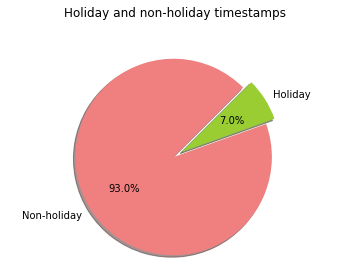

In [ ]:
# Pie chart of assigned leads versus un-assigned leads
colors_list = ['lightcoral', 'yellowgreen']
explode_list = [0.1, 0]
labels = ['Non-holiday', 'Holiday']
sizes = [sales_training['Holiday'].value_counts()[0], sales_training['Holiday'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, startangle=45, autopct='%1.1f%%', colors=colors_list, explode=explode_list, shadow=True)
plt.title('Holiday and non-holiday timestamps', y=1.12) 
ax1.axis('equal')
plt.show()
# From our analysis, 93% (391,906) of the sales data are recorded as holidays and 7% (29,661) of the sales are non-holidays.

In [ ]:
#setting up the data sources and preparing the data for uni-variate time series analysis
sales_training = sales_training.copy()
sales_training['Date'] = pd.to_datetime(sales_training['Date'])
sales_training.set_index(sales_training['Date'], inplace=True)
sales_training=sales_training.drop(columns=['Date'])
################
sales_testing = sales_testing.copy()

In [ ]:
sales_testing['Date'] = pd.to_datetime(sales_testing['Date'])
sales_testing.set_index(sales_testing['Date'], inplace=True)
sales_testing=sales_testing.drop(columns=['Date'])

In [ ]:
print ("We have sales data starting from",sales_training.index.min())
print ("End date",sales_testing.index.max())

We have sales data starting from 2010-02-05 00:00:00
End date 2012-10-26 00:00:00


In [ ]:
sales_testing['IsHoliday'] = sales_testing['IsHoliday'].astype('str')
sales_testing['Holiday'] = sales_testing['IsHoliday'].map({'False': 0,'True': 1}).astype('int')
sales_testing['Holiday'].value_counts()

0    3
Name: Holiday, dtype: int64

In [ ]:
sales_testing # Snapshot of the test forecast

,Store,Dept,Weekly_Sales,IsHoliday,Holiday
Date,,,,,
2012-10-12,45,98,1061.02,False,0
2012-10-19,45,98,760.01,False,0
2012-10-26,45,98,1076.80,False,0


In [ ]:
sales_training = sales_training[['Weekly_Sales']]

In [ ]:
# Understanding the missing values; what percent of missing values are contained within each column

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
# Missing values statistics
missing_values = missing_values_table(df)
missing_values.head(20)

Your selected dataframe has 5 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [ ]:
sales_training.dtypes

Weekly_Sales    float64
dtype: object

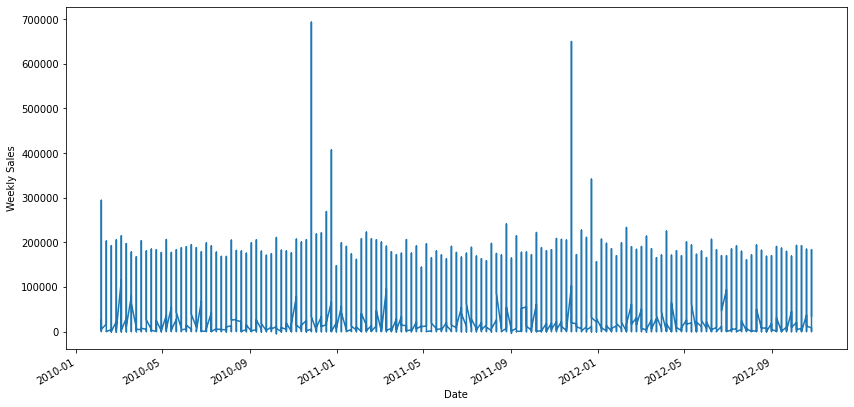

In [ ]:
#Just a plot of the weekly sales time series forecast
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
sales_training.Weekly_Sales.plot(figsize=(14, 7))

In [ ]:
# A formal way of testing stationarity of a dataset is using plotting the moving average or moving variance and see if the series mean and variance varies with time.
# This approach will be handled by using the TestStationaryPlot() method below;

def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window = 3, center = False).mean()
    rol_std = ts.rolling(window = 3, center = False).std()
    
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Weeks', fontsize = 10)
    plt.ylabel('Total Sales', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 10)
    plt.show(block= True)

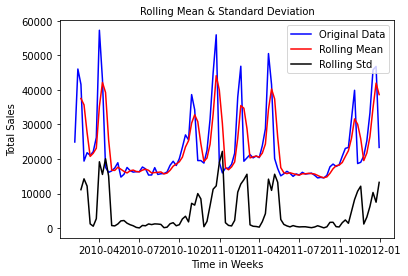

In [ ]:
TestStationaryPlot(sales_training.head(100))

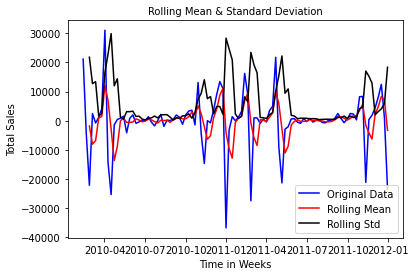

In [ ]:
sales_first_difference = sales_training.head(100) - sales_training.head(100).shift(1)  
TestStationaryPlot(sales_first_difference.head(100).dropna(inplace=False))

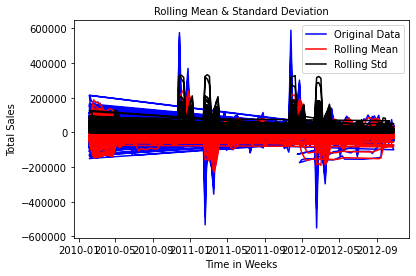

In [ ]:
sales_first_difference = sales_training - sales_training.shift(12)  
TestStationaryPlot(sales_first_difference.dropna(inplace=False))

In [ ]:
import itertools
p = d = q = range(0, 2) # Define the p, d and q parameters to take any value between 0 and 2
pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
pdq_x_QDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal p, q and q triplets
print('Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], pdq_x_QDQs[1]))
print('SARIMAX: {} x {}'.format(pdq[2], pdq_x_QDQs[2]))
print(pdq)
print(pdq_x_QDQs)
for param in pdq:
    for seasonal_param in pdq_x_QDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(sales_training['Weekly_Sales'],
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
a=[]
b=[]
c=[]
wf=pd.DataFrame()

Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [ ]:
for param in pdq:
    for param_seasonal in pdq_x_QDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(sales_training['Weekly_Sales'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            a.append(param)
            b.append(param_seasonal)
            c.append(results.aic)
        except:
            continue
wf['pdq']=a
wf['pdq_x_QDQs']=b
wf['aic']=c
print(wf[wf['aic']==wf['aic'].min()])

Empty DataFrame
Columns: [pdq, pdq_x_QDQs, aic]
Index: []


In [ ]:
# Performing an Augmented Dickey–Fuller test:
# Null Hypothesis (): Time series possesses a unit-root and is non-stationary
# Alternate Hypothesis: Time series is Stationary
# p-values is ~ 0 and test statistics is less than our critical values;

print('Results of Dickey Fuller Test:')
dftest = adfuller(sales_training['Weekly_Sales'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                    -31.988640
p-value                             0.000000
#Lags Used                         97.000000
Number of Observations Used    421469.000000
Critical Value (1%)                -3.430366
Critical Value (5%)                -2.861547
Critical Value (10%)               -2.566774
dtype: float64


In [ ]:
df_subset = df.loc[:200000].copy()
df_subset['Date'] = pd.to_datetime(df_subset['Date'])
df_subset.set_index(df_subset['Date'], inplace=True)
df_subset=df_subset.drop(columns=['Date'])

In [ ]:
df_subset = df_subset[['Weekly_Sales']]
print("length of subset", len(df_subset))
print("Remaining Test Set", len(df)-len(df_subset))

length of subset 200001
Remaining Test Set 221569


In [ ]:
df_subset

,Weekly_Sales
Date,
2010-02-05,24924.50
2010-02-12,46039.49
2010-02-19,41595.55
2010-02-26,19403.54
2010-03-05,21827.90
...,...
2011-02-25,2259.38
2011-03-04,2236.82
2011-03-11,2833.99


In [ ]:
df_subset_test = df.loc[200001:].copy()
df_subset_test['Date'] = pd.to_datetime(df_subset_test['Date'])
df_subset_test.set_index(df_subset_test['Date'], inplace=True)
df_subset_test=df_subset_test.drop(columns=['Date'])

In [ ]:
# Fitting an Auto-Arima Model to detect values of p,d,q | P,D,Q with seasonal components
model = auto_arima(df_subset['Weekly_Sales'], seasonal=True, trace=True, error_action="ignore", stepwise=True, suppress_warnings=True)
model.fit(df_subset['Weekly_Sales'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4135923.303, Time=71.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4174752.316, Time=3.92 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4151429.422, Time=8.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4140298.285, Time=12.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4174750.316, Time=2.84 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4136546.097, Time=101.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4137421.760, Time=68.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4133342.395, Time=67.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4133634.173, Time=63.48 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4130173.572, Time=147.22 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4133545.504, Time=99.79 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=4128541.335, Time=172.59 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4128630.646, Time=124.57 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=4128

ARIMA(maxiter=50, method='lbfgs', order=(5, 1, 3), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               200001
Model:               SARIMAX(5, 1, 3)   Log Likelihood            -2064173.061
Date:                Fri, 04 Jun 2021   AIC                        4128364.122
Time:                        02:47:24   BIC                        4128455.976
Sample:                             0   HQIC                       4128391.156
                             - 200001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4439      0.008     57.593      0.000       0.429       0.459
ar.L2         -0.0324      0.003    -10.169      0.000      -0.039      -0.026
ar.L3          0.0815      0.003     23.416      0.0

In [ ]:
forecast = model.predict(n_periods=len(df_subset_test))
df_subset_test["Forecast_SARIMAX"] = forecast

In [ ]:
df_subset_test.head(3)

,Store,Dept,Weekly_Sales,IsHoliday,Forecast_SARIMAX
Date,,,,,
2011-04-01,21,19,2350.98,False,2475.078862
2011-04-08,21,19,2386.24,False,2572.951196
2011-04-15,21,19,1822.65,False,2397.088598


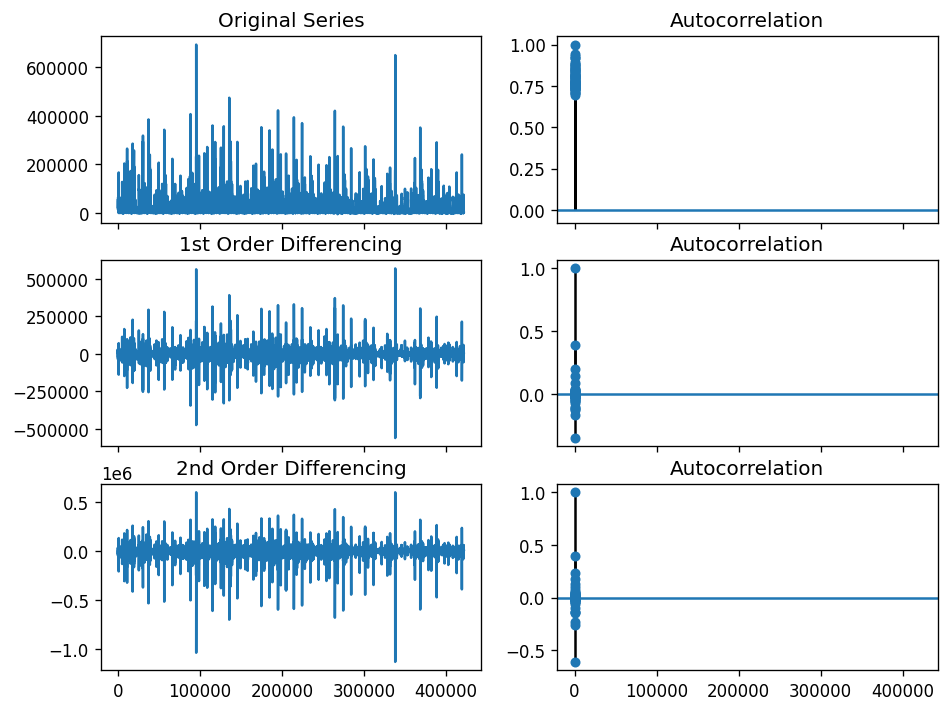

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.Weekly_Sales); axes[0, 0].set_title('Original Series')
plot_acf(df.Weekly_Sales, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.Weekly_Sales.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.Weekly_Sales.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.Weekly_Sales.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.Weekly_Sales.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

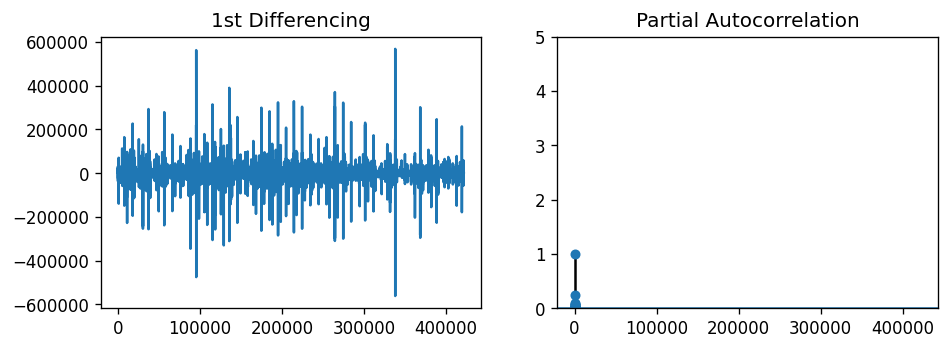

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.Weekly_Sales.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.Weekly_Sales.diff().dropna(), ax=axes[1])

plt.show()

#We can see that the PACF lag 1 is quite significant since it is well above the significance line. So, we will fix the value of p as 1.

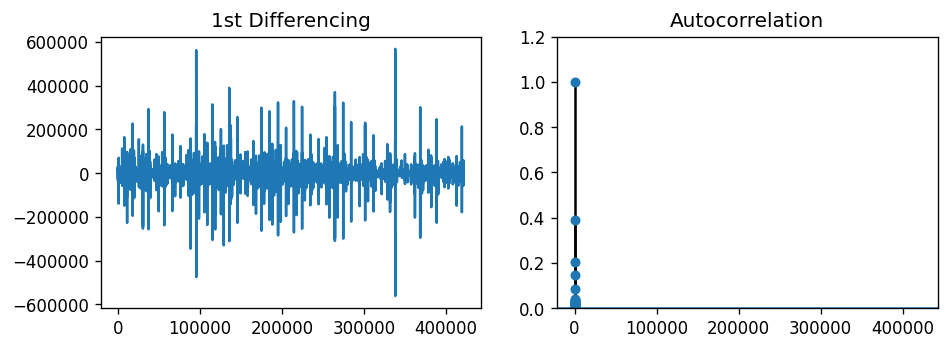

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.Weekly_Sales.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.Weekly_Sales.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
sales_training['Weekly_Sales'].describe()

count    420209.000000
mean      16033.222160
std       22729.537596
min           0.010000
25%        2120.160000
50%        7661.740000
75%       20271.400000
max      693099.360000
Name: Weekly_Sales, dtype: float64

In [ ]:
sales_training = sales_training[sales_training != 0]

In [ ]:
sales_training.Weekly_Sales

Date
2010-02-05    24924.50
2010-02-12    46039.49
2010-02-19    41595.55
2010-02-26    19403.54
2010-03-05    21827.90
                ...   
2012-09-07      352.44
2012-09-14      605.96
2012-09-21      467.30
2012-09-28      508.37
2012-10-05      628.10
Name: Weekly_Sales, Length: 421567, dtype: float64

In [ ]:
model = auto_arima(sales_training.Weekly_Sales, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8638901.285, Time=25.47 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9823077.537, Time=3.94 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8714130.878, Time=4.70 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9433454.272, Time=35.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8635382.540, Time=46.46 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8663806.714, Time=5.95 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8635138.650, Time=77.63 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8648760.548, Time=7.62 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=8633270.001, Time=107.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8637827.929, Time=123.52 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=8624581.104, Time=163.00 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8628448.570, Time=93.81 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=8623918.418, Time=302.03 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=86281

In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               421567
Model:               SARIMAX(3, 0, 3)   Log Likelihood            -4311951.209
Date:                Fri, 04 Jun 2021   AIC                        8623918.418
Time:                        00:11:50   BIC                        8624006.032
Sample:                             0   HQIC                       8623943.397
                             - 421567                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    344.6959     19.763     17.441      0.000     305.960     383.431
ar.L1          0.0098      0.001      7.604      0.000       0.007       0.012
ar.L2          0.5411      0.001    530.199      0.0


---
** The coefficient column shows the weight (i.e importance) of each featue and 
how each one impacts the final forecast. 
The P>|Z| column informs us of the significance of each feature weight. 
Each weight has a p-value close to 0, so we can include the features in our model**


In [ ]:
sales_testing=sales_testing[['Weekly_Sales']]
model.fit(sales_training.Weekly_Sales)
forecast = model.predict(n_periods=len(sales_testing))
sales_testing["Forecast_ARIMAX"] = forecast

In [ ]:
print(sales_testing)

            Weekly_Sales  Forecast_ARIMAX
Date                                     
2012-10-12       1061.02       918.591999
2012-10-19        760.01      1031.313531
2012-10-26       1076.80      1174.828432


In [ ]:
# Evaluating the Accuracy Metrics - Mape, Me, Mae - Mean Absolute Error #
def forecast_accuracy(forecast, actual):

    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # Mean absolute percentage error
    me = np.mean(forecast - actual)             # Mean Error
    mae = np.mean(np.abs(forecast - actual))    # Mean Absolute Error
    mpe = np.mean((forecast - actual)/actual)   # Mean Percentage Error
    rmse = np.mean((forecast - actual)**2)**.5  # Root Mean Squared Error
    corr = np.corrcoef(forecast, actual)[0,1]   # Correlation between Actual and Forecast
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]    # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [ ]:
print("Printing Different forecast Metrics\n\n",forecast_accuracy(sales_testing.Forecast_ARIMAX, sales_testing.Weekly_Sales))

Printing Different foreast Metrics

 {'mape': 0.19408243539015538, 'me': 75.63465418862408, 'mae': 170.58665470674964, 'mpe': 0.1045911906274501, 'rmse': 185.74257723240405, 'acf1': -0.4434410833510887, 'corr': 0.11324061093117725, 'minmax': 0.16024783641709017}


In [ ]:
sales_training = sales_training[['Weekly_Sales','Holiday']]

In [ ]:
## Fitting an Arima model with Exogenous variables;

from statsmodels.tsa.arima_model import ARIMA
model = auto_arima(sales_training[['Weekly_Sales']], exogenous=sales_training[['Holiday']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8808718.267, Time=75.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14850224.714, Time=7.46 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8714078.221, Time=175.26 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9469846.592, Time=103.33 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8851707.051, Time=19.31 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8807958.809, Time=110.91 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8710407.324, Time=145.83 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=9666751.436, Time=8.96 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8849312.434, Time=22.95 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8813832.079, Time=67.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=9357973.470, Time=132.85 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8813762.990, Time=87.80 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 960.929 seconds


In [ ]:
sales_testing['Date'] = pd.to_datetime(sales_testing['Date'])
sales_testing.set_index(sales_testing['Date'], inplace=True)
sales_testing=sales_testing.drop(columns=['Date'])

In [ ]:
model.fit(sales_training[['Weekly_Sales']], exogenous=sales_training[['Holiday']])
forecast = model.predict(n_periods=len(sales_testing), exogenous=sales_training['Holiday'])
sales_testing["Forecast_ARIMAX_EXOG"] = forecast

In [ ]:
sales_testing

,Weekly_Sales,Forecast_ARIMAX_EXOG
421567,1061.02,1470.343772
421568,760.01,2266.380992
421569,1076.80,3018.746610


In [ ]:
print("Printing Different foreast Metrics\n\n",
      forecast_accuracy(sales_testing.Forecast_ARIMAX_EXOG, sales_testing.Weekly_Sales))

Printing Different foreast Metrics

 {'mape': 1.3904221792118212, 'me': 1285.8804581142583, 'mae': 1285.8804581142583, 'mpe': 1.3904221792118212, 'rmse': 1438.5010895118473, 'acf1': -0.038974223194780756, 'corr': 0.027925694024376613, 'minmax': 0.5287804382722758}


In [ ]:
sales_testing['Date'] = pd.to_datetime(sales_testing['Date'])
sales_testing.set_index(sales_testing['Date'], inplace=True)
sales_testing=sales_testing.drop(columns=['Date'])

In [ ]:
sales_testing = sales_testing[['Weekly_Sales']]

In [ ]:
# 3,0,3 ARIMA Model - Validating the ARIMA model
model = ARIMA(sales_training['Weekly_Sales'], order=(3,0,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                              ARMA Model Results                              
Dep. Variable:           Weekly_Sales   No. Observations:               421567
Model:                     ARMA(3, 3)   Log Likelihood            -4311949.974
Method:                       css-mle   S.D. of innovations           6697.195
Date:                Tue, 01 Jun 2021   AIC                        8623915.947
Time:                        18:30:22   BIC                        8624003.561
Sample:                             0   HQIC                       8623940.927
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.598e+04    499.693     31.982      0.000     1.5e+04     1.7e+04
ar.L1.Weekly_Sales     0.0090      0.006      1.440      0.150      -0.003       0.021
ar.L2.Weekly_Sales  

In [ ]:
start = len(sales_training)
end = len(sales_training) + len(sales_testing)-1
pred = model_fit.predict(start=start, end=end, exog=None, dynamic=False)
sales_testing["Forecast_ARIMA"] = pred.values

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [ ]:
forecast_accuracy(sales_testing.Forecast_ARIMA, sales_testing.Weekly_Sales)

{'acf1': -0.5273264495937352,
 'corr': -0.034563610417804,
 'mae': 159.27832621379636,
 'mape': 0.18544092129498754,
 'me': 70.66656879187853,
 'minmax': 0.15018724462899335,
 'mpe': 0.10192528782726984,
 'rmse': 185.2580637320316}

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

smodel = pm.auto_arima(df_subset['Weekly_Sales'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=959.91 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=4377470.066, Time=8.43 sec


In [ ]:
import itertools
import statsmodels.api as sm


p = d = q = range(0, 2) # Define the p, d and q parameters to take any value between 0 and 2
pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
pdq_x_QDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal p, q and q triplets
print('Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], pdq_x_QDQs[1]))
print('SARIMAX: {} x {}'.format(pdq[2], pdq_x_QDQs[2]))

Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)


In [ ]:
print(pdq)
print(pdq_x_QDQs)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [ ]:
for param in pdq:
    for seasonal_param in pdq_x_QDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(sales_training,
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:9823054.430101244
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:9603547.943218032
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:9130129.278262202


In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in pdq_x_QDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(sales_training,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            a.append(param)
            b.append(param_seasonal)
            c.append(results.aic)
        except:
            continue
wf['pdq']=a
wf['pdq_x_QDQs']=b
wf['aic']=c
print(wf[wf['aic']==wf['aic'].min()])


Empty DataFrame
Columns: [pdq, pdq_x_QDQs, aic]
Index: []


In [ ]:
import itertools
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(sales_training['Weekly_Sales'],order=(1,0,1), seasonal_order=(0,1,1,12), enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary())

In [ ]:
start = len(sales_training)
end = len(sales_training) + len(sales_testing)-1
pred = results.predict(start=start, end=end, exog=None, dynamic=False)
sales_testing["Forecast_SARIMAX"] = pred.values

NameError: ignored

,Store,Dept,Weekly_Sales,IsHoliday,Forecast_SARIMAX
Date,,,,,
2012-10-12,45,98,1061.02,False,557.752226
2012-10-19,45,98,760.01,False,576.722219
2012-10-26,45,98,1076.80,False,532.000673


In [ ]:
import statsmodels.api as sm
mod1 = sm.tsa.statespace.SARIMAX(sales_training, 
                                order=(1,1,1), 
                                seasonal_order=(0,1,1,12),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod1.fit()
print(results.summary())

In [ ]:
## FB - prophet model for time series analysis;

sales_training['ds'] = pd.DatetimeIndex(sales_training['Date'])
sales_training = sales_training[['ds', 'Weekly_Sales']]

In [ ]:
sales_training.rename(columns = {'Weekly_Sales':'y'}, inplace = True)
sales_train_fb_prophet = sales_training.copy()

In [ ]:
# Fitting FB prophet; Model Training  
m = Prophet(interval_width=0.95, daily_seasonality=False)
model = m.fit(sales_train_fb_prophet)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [ ]:
sales_train_fb_prophet.tail(3)

,ds,y
421564,2012-09-21,467.30
421565,2012-09-28,508.37
421566,2012-10-05,628.10


In [ ]:
# Forecast Away 3 time weekly time frames;
future = m.make_future_dataframe(periods=6, freq='W')
forecast = m.predict(future)

In [ ]:
forecast.tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
139,2012-10-05,16372.156956,-26467.859729,61929.657388,16372.156956,16372.156956,-893.858177,-893.858177,-893.858177,-893.858177,-893.858177,-893.858177,0.0,0.0,0.0,15478.298779
140,2012-10-12,16383.148977,-26917.412506,56987.464919,16383.148977,16383.148977,-784.032773,-784.032773,-784.032773,-784.032773,-784.032773,-784.032773,0.0,0.0,0.0,15599.116204
141,2012-10-19,16394.140997,-30727.191089,58896.611394,16394.140997,16394.140997,-1042.685314,-1042.685314,-1042.685314,-1042.685314,-1042.685314,-1042.685314,0.0,0.0,0.0,15351.455683
142,2012-10-26,16405.133018,-30579.234447,61103.261301,16405.133018,16405.133018,-1116.758893,-1116.758893,-1116.758893,-1116.758893,-1116.758893,-1116.758893,0.0,0.0,0.0,15288.374124
143,2012-10-28,16408.273595,-26536.025561,58820.465753,16408.273595,16408.441777,-1026.159957,-1026.159957,-1026.159957,-1026.159957,-1026.159957,-1026.159957,0.0,0.0,0.0,15382.113638
144,2012-11-04,16419.265615,-24934.262400,61513.466160,16408.695996,16433.418391,-298.539173,-298.539173,-298.539173,-298.539173,-298.539173,-298.539173,0.0,0.0,0.0,16120.726442
145,2012-11-11,16430.257636,-29008.092711,61173.633671,16401.910878,16464.645987,681.189949,681.189949,681.189949,681.189949,681.189949,681.189949,0.0,0.0,0.0,17111.447584
146,2012-11-18,16441.249656,-23473.255757,58605.266686,16385.670834,16502.373726,1374.168552,1374.168552,1374.168552,1374.168552,1374.168552,1374.168552,0.0,0.0,0.0,17815.418208
147,2012-11-25,16452.241677,-25347.481452,59370.580285,16370.035204,16553.169543,1840.779294,1840.779294,1840.779294,1840.779294,1840.779294,1840.779294,0.0,0.0,0.0,18293.020971
148,2012-12-02,16463.233697,-23455.615776,62528.594656,16352.325298,16591.955299,2685.687129,2685.687129,2685.687129,2685.687129,2685.687129,2685.687129,0.0,0.0,0.0,19148.920826


In [ ]:
future.tail(11)

,ds
138,2012-09-28
139,2012-10-05
140,2012-10-12
141,2012-10-19
142,2012-10-26
143,2012-10-28
144,2012-11-04
145,2012-11-11
146,2012-11-18
147,2012-11-25


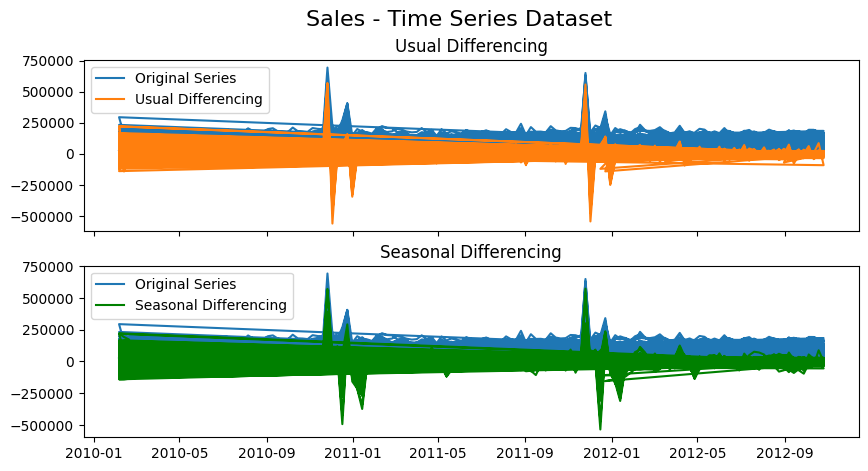

In [ ]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(sales_training[:], label='Original Series')
axes[0].plot(sales_training[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(sales_training[:], label='Original Series')
axes[1].plot(sales_training[:].diff(3), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Sales - Time Series Dataset', fontsize=16)
plt.show()